In [55]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [56]:
def count_columns(gzip_filename):
    chunks = pd.read_csv(gzip_filename, compression="gzip", index_col=0, chunksize=1, dtype=np.float32)
    for chunk in chunks:
        return len(chunk.columns)

In [57]:
# chunks の皆様
date_chunks = pd.read_csv("../output/reduced_train_date.csv.gz", compression="gzip", index_col=0, chunksize=100000, dtype=np.float32)
categorical_chunks = pd.read_csv("../output/reduced_train_categorical.csv.gz", compression="gzip", index_col=0, chunksize=100000, dtype=np.float32)
num_chunks = pd.read_csv("../output/reduced_train_numeric.csv.gz", compression="gzip", index_col=0, chunksize=100000, dtype=np.float32, usecols=list(range(969)))

In [84]:
def use_cols_list(train_files):
    count_list = []
    for train_file in train_files:
        count_list.append(count_columns(train_file))
    count_list.append(100000)

    cols_list = []
    cur = 0
    for counts in count_list:
        l = cur
        cur += counts
        r = cur
        print(l, r)

train_files = [
    "../output/reduced_train_date.csv.gz",
    "../output/reduced_train_categorical.csv.gz",
]
use_cols_list(train_files)

0 161
161 408


In [59]:
X = pd.concat([
        pd.concat([d, c, n], axis=1)
        for d, c, n in zip(date_chunks, categorical_chunks, num_chunks)
    ])

ValueError: not enough values to unpack (expected 3, got 1)

In [22]:
y = pd.read_csv("../output/reduced_train_numeric.csv.gz", compression="gzip", index_col=0, usecols=[0,969], dtype=np.float32)

In [23]:
y = y.loc[X.index].values.ravel()

In [24]:
X = X.values

In [25]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[   0   19  122  126  127  128  131  134  135  136  140  142  143  380  418
  419  608  691  728  729  746  749  764  768  775  800 1090 1095 1098 1100
 1110 1112 1139 1140 1141 1143 1150 1159 1207 1219 1226 1234 1236 1239 1244
 1251 1258 1259 1262 1280 1291]


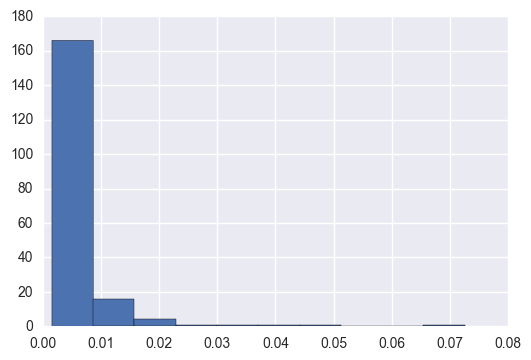

In [26]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [37]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = count_columns("../output/reduced_train_date.csv.gz")
n_categorical_features = count_columns("../output/reduced_train_categorical.csv.gz")

usecols_date = np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])
important_indices2 = important_indices[important_indices >= n_date_features]
usecols_categorical = np.concatenate([[0], important_indices2[important_indices2 < n_date_features + n_categorical_features] + 1 - n_date_features])
usecols_numeric = np.concatenate([[0], important_indices[important_indices >= (n_date_features + n_categorical_features)] + 1 - n_date_features - n_categorical_features])

X = np.concatenate([
    pd.read_csv("../output/reduced_train_date.csv.gz", index_col=0, dtype=np.float32,
                usecols=usecols_date).values,
    pd.read_csv("../output/reduced_train_categorical.csv.gz", index_col=0, dtype=np.float32,
                usecols=usecols_categorical).values,
    pd.read_csv("../output/reduced_train_numeric.csv.gz", index_col=0, dtype=np.float32,
                usecols=usecols_numeric).values
], axis=1)
y = pd.read_csv("../output/reduced_train_numeric.csv.gz", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [88]:
n_date_features + n_categorical_features

408

In [38]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)

In [39]:
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.725
fold 1, ROC AUC: 0.710
fold 2, ROC AUC: 0.707
0.713623304108


0.247377601196


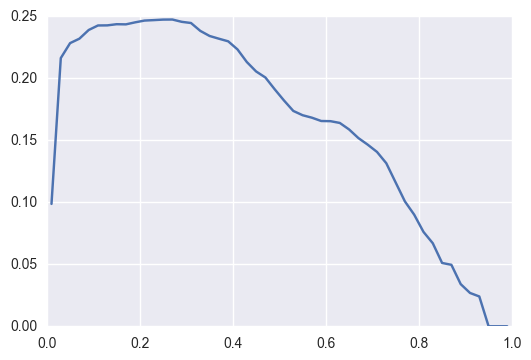

In [40]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [52]:
X = np.concatenate([
    pd.read_csv("../output/reduced_test_date.csv.gz", index_col=0, dtype=np.float32,
                usecols=usecols_date).values,
    pd.read_csv("../output/reduced_test_categorical.csv.gz", index_col=0, dtype=np.float32,
                usecols=usecols_categorical).values,
    pd.read_csv("../output/reduced_test_numeric.csv.gz", index_col=0, dtype=np.float32,
                usecols=usecols_numeric).values
], axis=1)

In [53]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [54]:
# and submit
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")

In [90]:
numeric = pd.read_csv("../output/reduced_train_numeric.csv.gz", index_col=0, dtype=np.float32, usecols=list(range(969)))

In [91]:
response = pd.read_csv("../output/reduced_train_numeric.csv.gz", index_col=0, dtype=np.float32, usecols=[0, 969])

In [93]:
numeric.to_csv("../output/reduced_train_numeric.csv.gz", compression="gzip")

In [95]:
response.to_csv("../output/train_response.csv.gz", compression="gzip")